In [46]:
import os
import time
import numpy as np
from numpy.linalg import pinv, solve, norm
from PIL import Image
from matplotlib import image
from matplotlib import pyplot as plt
from scipy.linalg import lu, qr, lstsq

In [47]:
img_dir = 'test_images'

def impth(name):
    return os.path.join(img_dir, name + '_original.png')

def load_image(path):
    img = Image.open(path)
    img = np.array(img)
    return img.astype(np.float64)/255
    
def show_imgs(imgs, names, title=''):
    n = len(imgs)
    cols = min(4, n)
    rows = (n + cols - 1) // cols
    
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axs = axs.flatten() if n > 1 else [axs]
    
    for i, img in enumerate(imgs):
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(names[i])
    
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    if title:
        fig.suptitle(title, fontsize=16, y=0.95)
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def psnr(X_rec, X):
    mse = np.mean((X_rec - X) ** 2)
    if mse == 0:
        return float('inf')
    if np.max(X_rec) > 1 or np.max(X) > 1:
        print(np.max(X_rec), np.max(X))
        return 10 * np.log10(255**2 / mse)
    return 10 * np.log10(1 / mse)

def rel_error(X_rec, X):
    return norm(X_rec - X, 'fro') / norm(X, 'fro')

## (a) Blur the image

In [48]:
def blurring_kernel(n, j, k):
    N = 2*n - 1
    values = np.zeros(N)
    values[n+j-k:n+j] = 2*np.arange(1,k+1)/(k*(k+1))
    kernel = np.zeros((n,n))
    
    for i in range(n):
        kernel[:, i] = values[n-i-1:N-i]
    return kernel

In [49]:
blurring_kernel(5, 0, 2)

array([[0.66666667, 0.33333333, 0.        , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.66666667, 0.33333333, 0.        ],
       [0.        , 0.        , 0.        , 0.66666667, 0.33333333],
       [0.        , 0.        , 0.        , 0.        , 0.66666667]])

In [50]:
blurring_kernel(5, 1, 3)

array([[0.33333333, 0.16666667, 0.        , 0.        , 0.        ],
       [0.5       , 0.33333333, 0.16666667, 0.        , 0.        ],
       [0.        , 0.5       , 0.33333333, 0.16666667, 0.        ],
       [0.        , 0.        , 0.5       , 0.33333333, 0.16666667],
       [0.        , 0.        , 0.        , 0.5       , 0.33333333]])

In [51]:
def blur_image(X, Al, Ar):
    return Al @ X @ Ar

In [52]:
def blur(imname, jkL=(0,12), jkR=(1,24), if_show=False):
    X = load_image(impth(imname))
    
    n = X.shape[0]
    Al = blurring_kernel(n, jkL[0], jkL[1])
    Ar = blurring_kernel(n, jkR[0], jkR[1])
    
    B = blur_image(X, Al, Ar)
    if if_show:
        show_imgs([X, B],
                ['Original', 'Blurred'],
                title = imname + ' | Original vs Blurred' 
                  + f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR[0]}, k\'={jkR[1]})'
                )
    return X, B, Al, Ar

In [53]:
img_list = [
    '256_hand',
    '512_ducks',
    '1024_books',
    '2048_mountain',
    # '4096_husky' # too large
]

jkL = (0, 12)
jkR1 = (1, 24)
jkR2 = (1, 36)

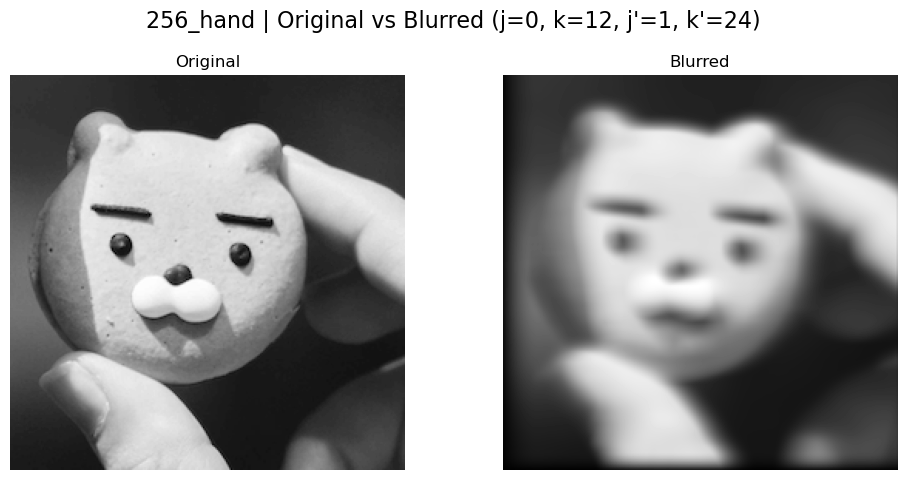

In [54]:
X1, B1, Al1, Ar1 = blur(img_list[0], jkL, jkR1, if_show=True)

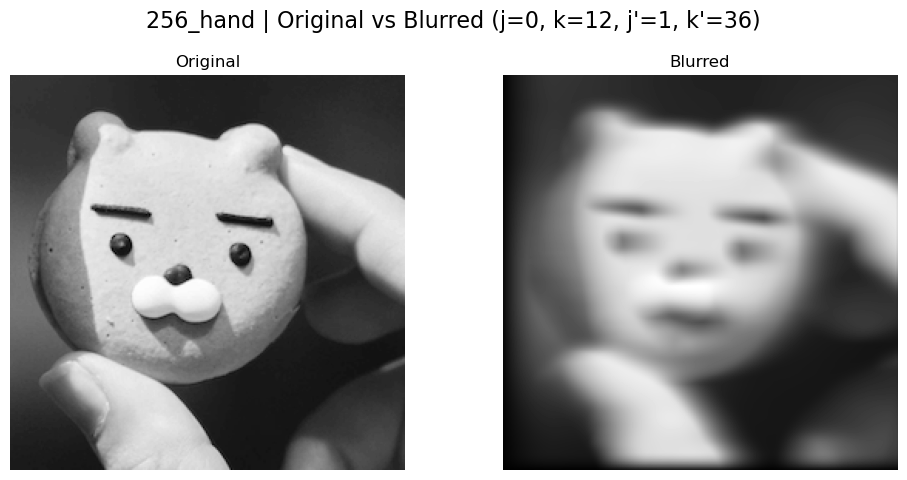

In [55]:
X2, B2, Al2, Ar2 = blur(img_list[0], jkL, jkR2, if_show=True)

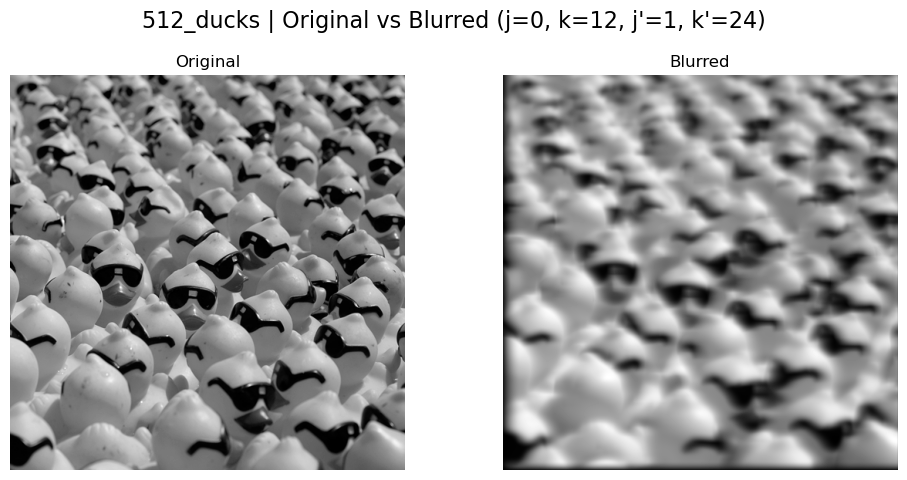

In [56]:
X3, B3, Al3, Ar3 = blur(img_list[1], jkL, jkR1, if_show=True)

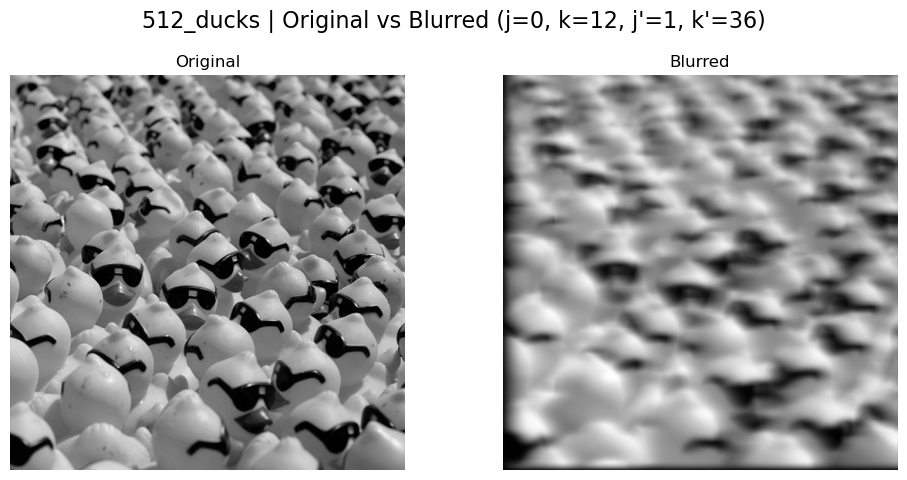

In [57]:
X4, B4, Al4, Ar4 = blur(img_list[1], jkL, jkR2, if_show=True)

## (b) Deblur the image using builtin LU and QR functions

In [58]:
def recover_by_LU(B, Al, Ar, lu_func=lu):
    t1 = time.time()
    _, Lr, Ur = lu_func(Ar, permute_l=False)
    X_rec = pinv(Al) @ B @ pinv(Ur) @ pinv(Lr)
    t2 = time.time()
    return np.clip(X_rec, 0, 1), t2-t1

def recover_by_QR(B, Al, Ar, qr_func=qr):
    t1 = time.time()
    Qr, Rr = qr_func(Ar, pivoting=False)
    X_rec = pinv(Al) @ B @ pinv(Rr) @ Qr.T
    t2 = time.time()
    return np.clip(X_rec, 0, 1), t2-t1

## (c) Implement my Householder QR factorization

In [59]:
def my_qr(A, pivoting=False):
    '''Householder QR decomposition (without column pivoting)'''
    m, n = A.shape
    Q = np.eye(m)
    R = np.copy(A)

    for j in range(n):
        v = R[j:, j].copy()
        
        v[0] = v[0] + np.sign(v[0]) * norm(v) * v[0]
        v = v / norm(v)
        H = np.eye(len(v)) - 2 * np.outer(v, v)

        H_full = np.eye(m)
        H_full[j:, j:] = H
        R = H_full @ R
        Q = Q @ H_full.T
    return Q, R[:n, :]

## (d) & (e) Deblur the image using my Householder QR factorization and explore other methods

In [60]:
def recover_by_lstsq(B, Al, Ar):
    t1 = time.time()
    Y, _, _, _ = lstsq(Al, B)
    X_rec_t, _, _, _ = lstsq(Ar.T, Y.T)
    X_rec = X_rec_t.T
    t2 = time.time()
    return np.clip(X_rec, 0, 1), t2-t1

def recover_by_pure_pinv(B, Al, Ar):
    t1 = time.time()
    X_rec = pinv(Al) @ B @ pinv(Ar)
    t2 = time.time()
    return np.clip(X_rec, 0, 1), t2-t1

def recover_by_pad(B, Al, Ar):
    t1 = time.time()
    Y = pinv(Al) @ B
    
    ################################################################
    # [[X11 X12 ... 0],   [[1 Ar11 Ar12 ...],   [[X11          ]
    #  [X21 X22 ... 0], @  [0 Ar21 Ar22 ...], =  [X21   X@Ar   ] (Y)
    #  [... ... ... 0],    [0 ...  ...  ...],    [...          ]
    #  [0   0   ... 0]]    [0   0   0 ... 1]]    [0   0   ... 0]]
    #`##############################################################
    Y = np.pad(Y, ((0,1), (1,0)), mode='constant')
    # pad the first column by estimated values of X[:,0], assuming X[:,0] = X[:,1]
    Y[:-1, 0] = Y[:-1, 1] / (Ar[0,0] + Ar[1,0])
    
    Ar = np.pad(Ar, ((0,1), (1,0)), mode='constant')
    Ar[0,0] = 1; Ar[-1,-1] = 1
    
    X_rec = Y @ pinv(Ar)
    X_rec = X_rec[:-1, :-1]
    
    t2 = time.time()
    return np.clip(X_rec, 0, 1), t2-t1

---

## Deblurred image comparison for different methods

In [61]:
def plot_metrics_in_row(metrics, info=''):
    methods = [metric[0] for metric in metrics]
    
    epsilon = 1e-6  # Small constant to avoid log(0)
    log_relerrs = [np.log10(metric[3] + epsilon) for metric in metrics]
    
    metrics_dict = {
        "Execution Time": ([metric[1] for metric in metrics], "Time (s)", "green"),
        "PSNR": ([metric[2] for metric in metrics], "PSNR", "blue"),
        "Log Relative Error": (log_relerrs, "log10(Relative Error + ε)", "orange"),
    }
    
    fig, axs = plt.subplots(1, len(metrics_dict), figsize=(18, 6), constrained_layout=True)
    
    x = np.arange(len(methods))
    width = 0.6  # Width of bars

    # Plot each metric
    for ax, (title, (values, ylabel, color)) in zip(axs, metrics_dict.items()):
        ax.bar(x, values, width, color=color, alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("Methods")
        ax.set_ylabel(ylabel)
        ax.set_xticks(x)
        ax.set_xticklabels(methods, rotation=45, ha='right')
    
    fig.suptitle(f"Metrics Comparison for Deblurring Methods {info}", fontsize=16)
    plt.show()

def deblur_comparison(X, B, Al, Ar, info=''):
    methods = {
        "Builtin LU": lambda: recover_by_LU(B, Al, Ar, lu_func=lu),
        "Builtin QR": lambda: recover_by_QR(B, Al, Ar, qr_func=qr),
        "My QR": lambda: recover_by_QR(B, Al, Ar, qr_func=my_qr),
        "Least Squares": lambda: recover_by_lstsq(B, Al, Ar),
        "Pseudo-inverse": lambda: recover_by_pure_pinv(B, Al, Ar),
        "Padding": lambda: recover_by_pad(B, Al, Ar),
    }

    X_rec_list = []  # Store recovered matrices
    metrics = []  # Store metrics (name, t, psnr_val, relerr_val)

    for name, func in methods.items():
        X_rec, t = func()
        psnr_val = psnr(X_rec, X)
        relerr_val = rel_error(X_rec, X)
        X_rec_list.append(X_rec)
        metrics.append((name, t, psnr_val, relerr_val))

    title = "Deblurring Methods Comparison"
    if info: 
        title += f" ({info})"
    
    show_imgs(
        [X, B] + X_rec_list,
        ["Original", "Blurred"] + [
            f"{name} (PSNR={psnr_val:.2f}, RE={relerr_val:.2e}, t={t:.2f}s)"
            for name, t, psnr_val, relerr_val in metrics
        ],
        title=title
    )
    
    plot_metrics_in_row(metrics, info)
    
    return metrics

In [62]:
metrics_list = [[0] * len(img_list) for _ in range(2)]

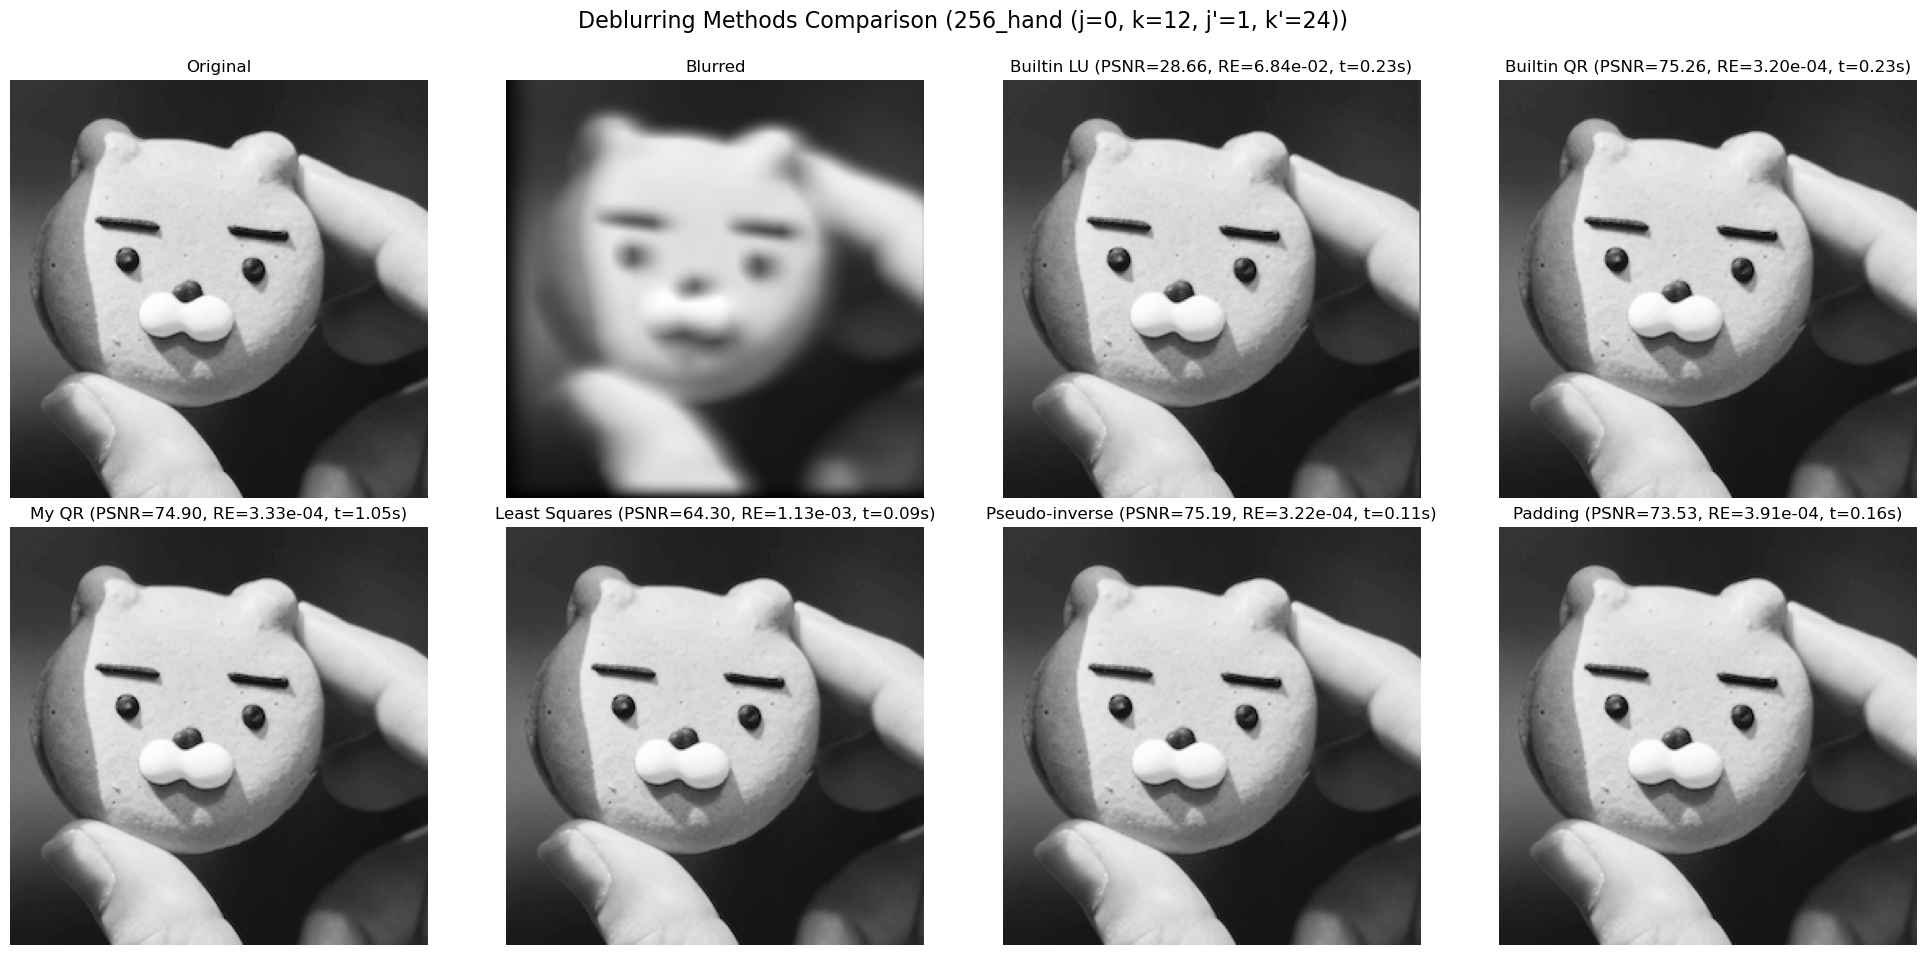

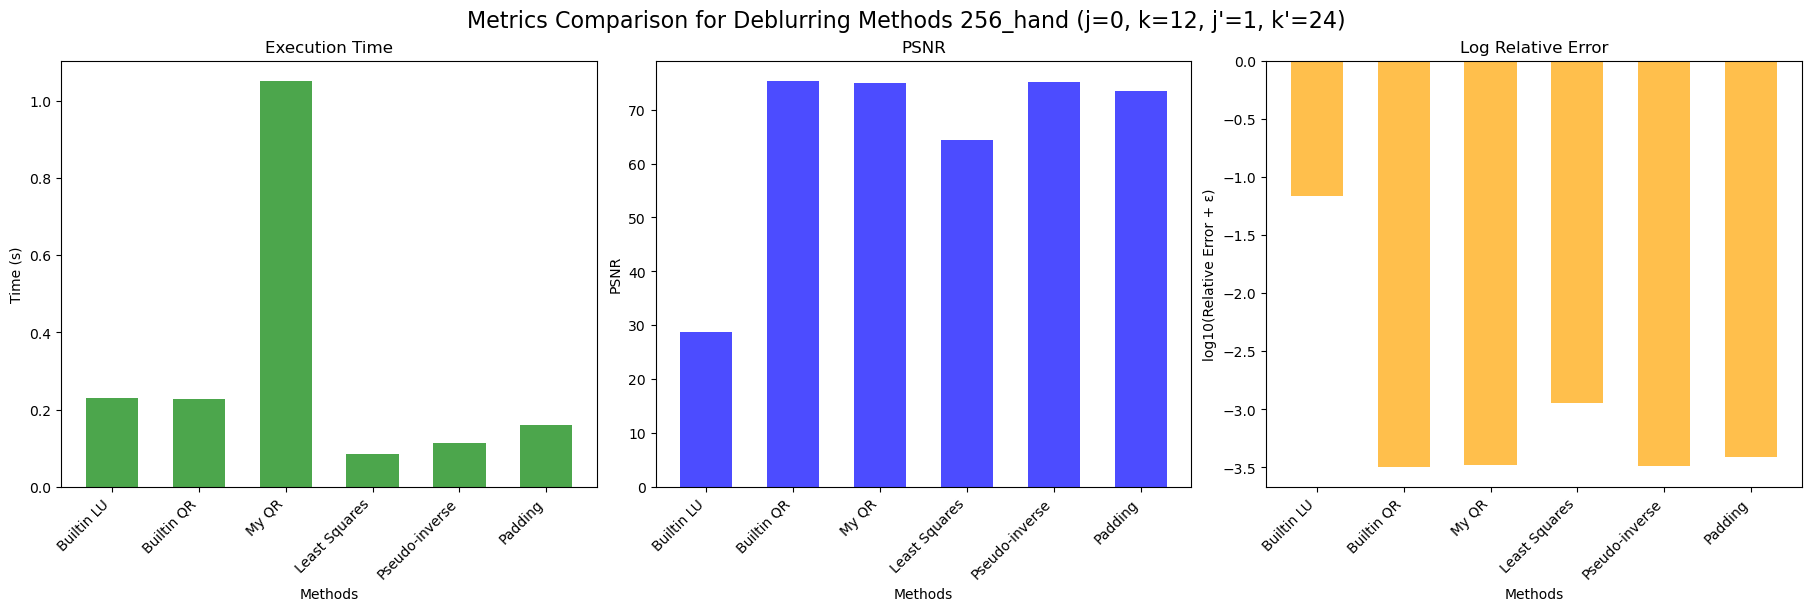

In [63]:
metrics_list[0][0] = deblur_comparison(X1, B1, Al1, Ar1,
                        info=img_list[0]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR1[0]}, k\'={jkR1[1]})')

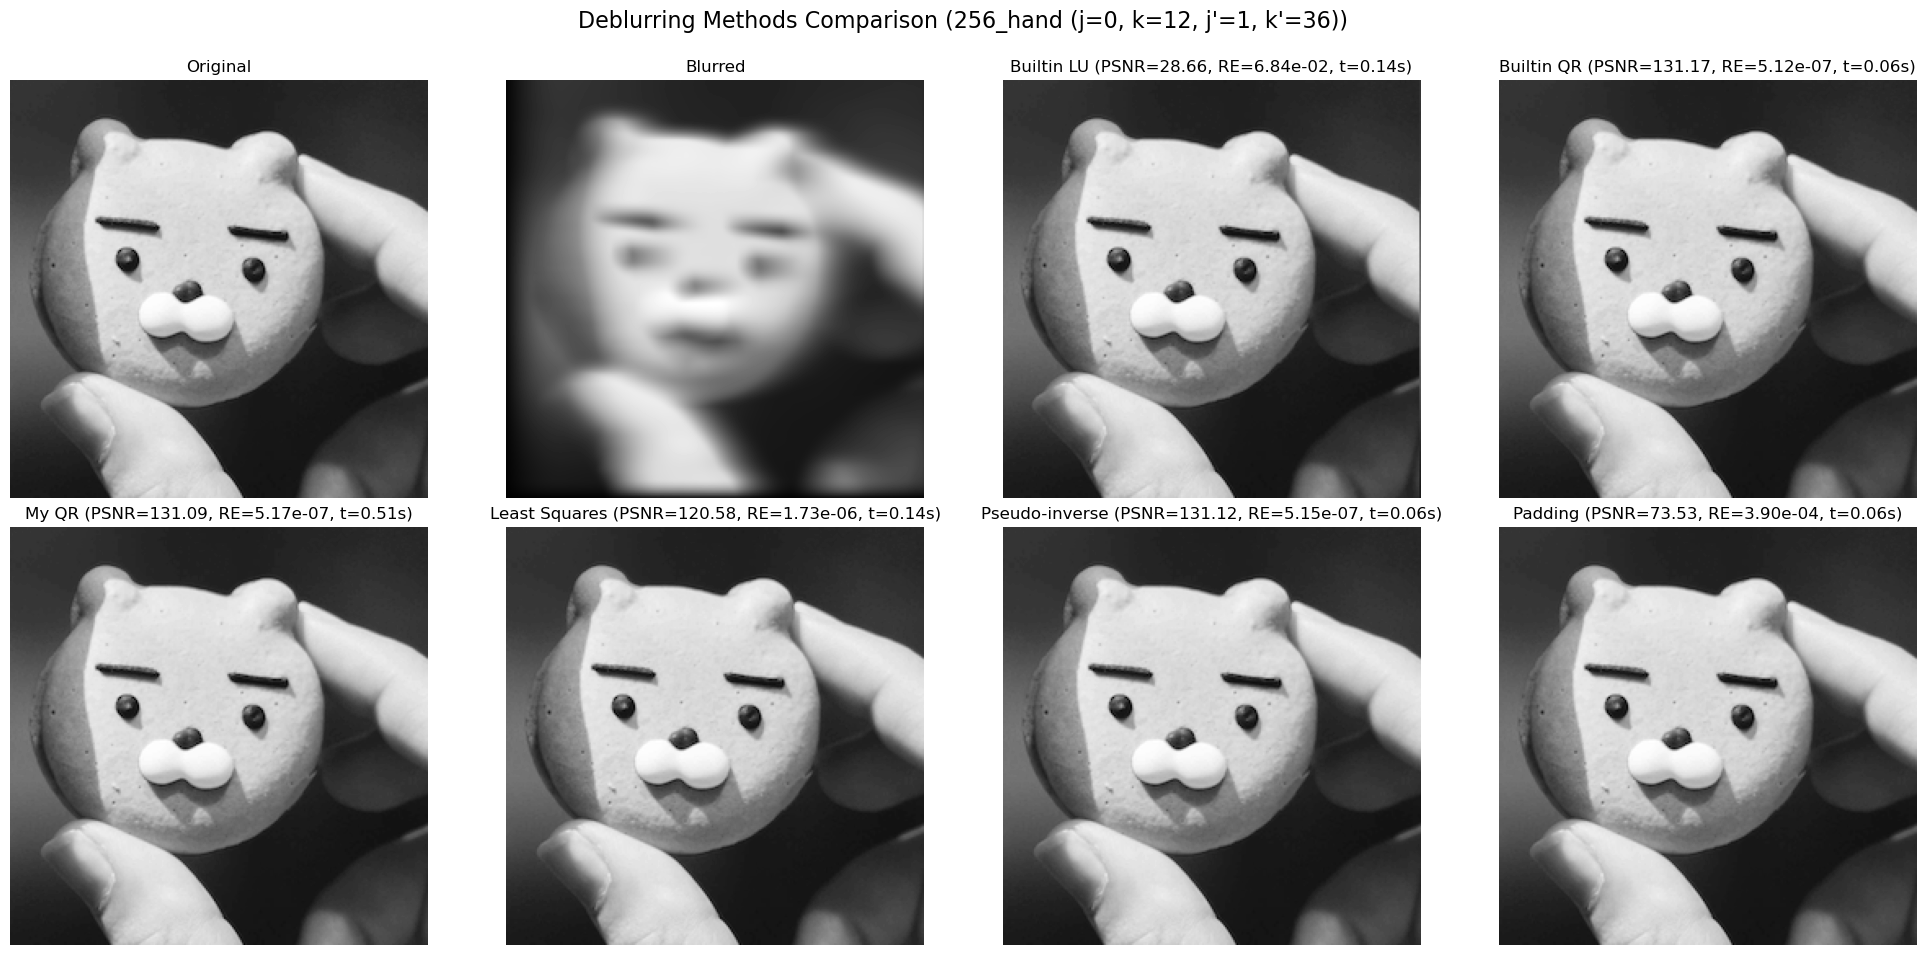

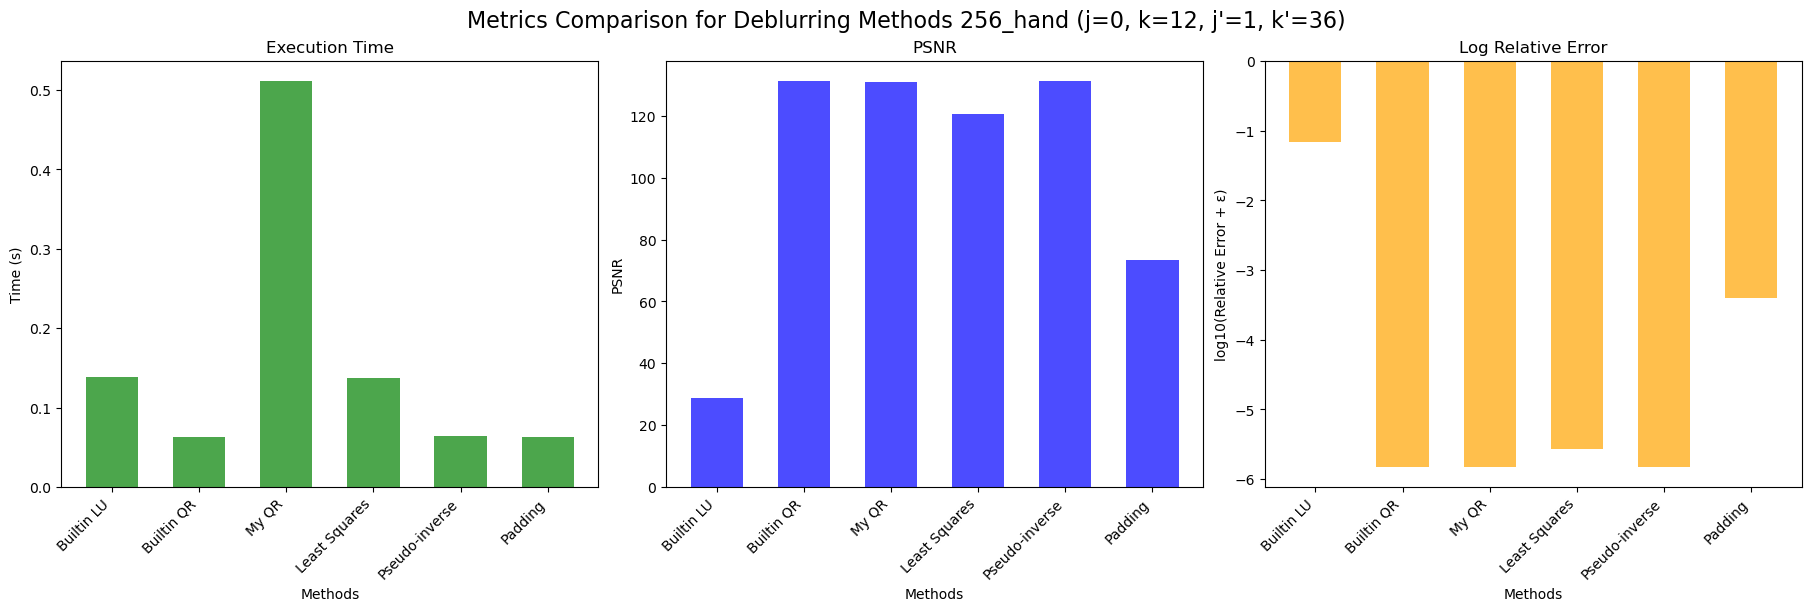

In [64]:
metrics_list[1][0] = deblur_comparison(X2, B2, Al2, Ar2,
                        info=img_list[0]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR2[0]}, k\'={jkR2[1]})')

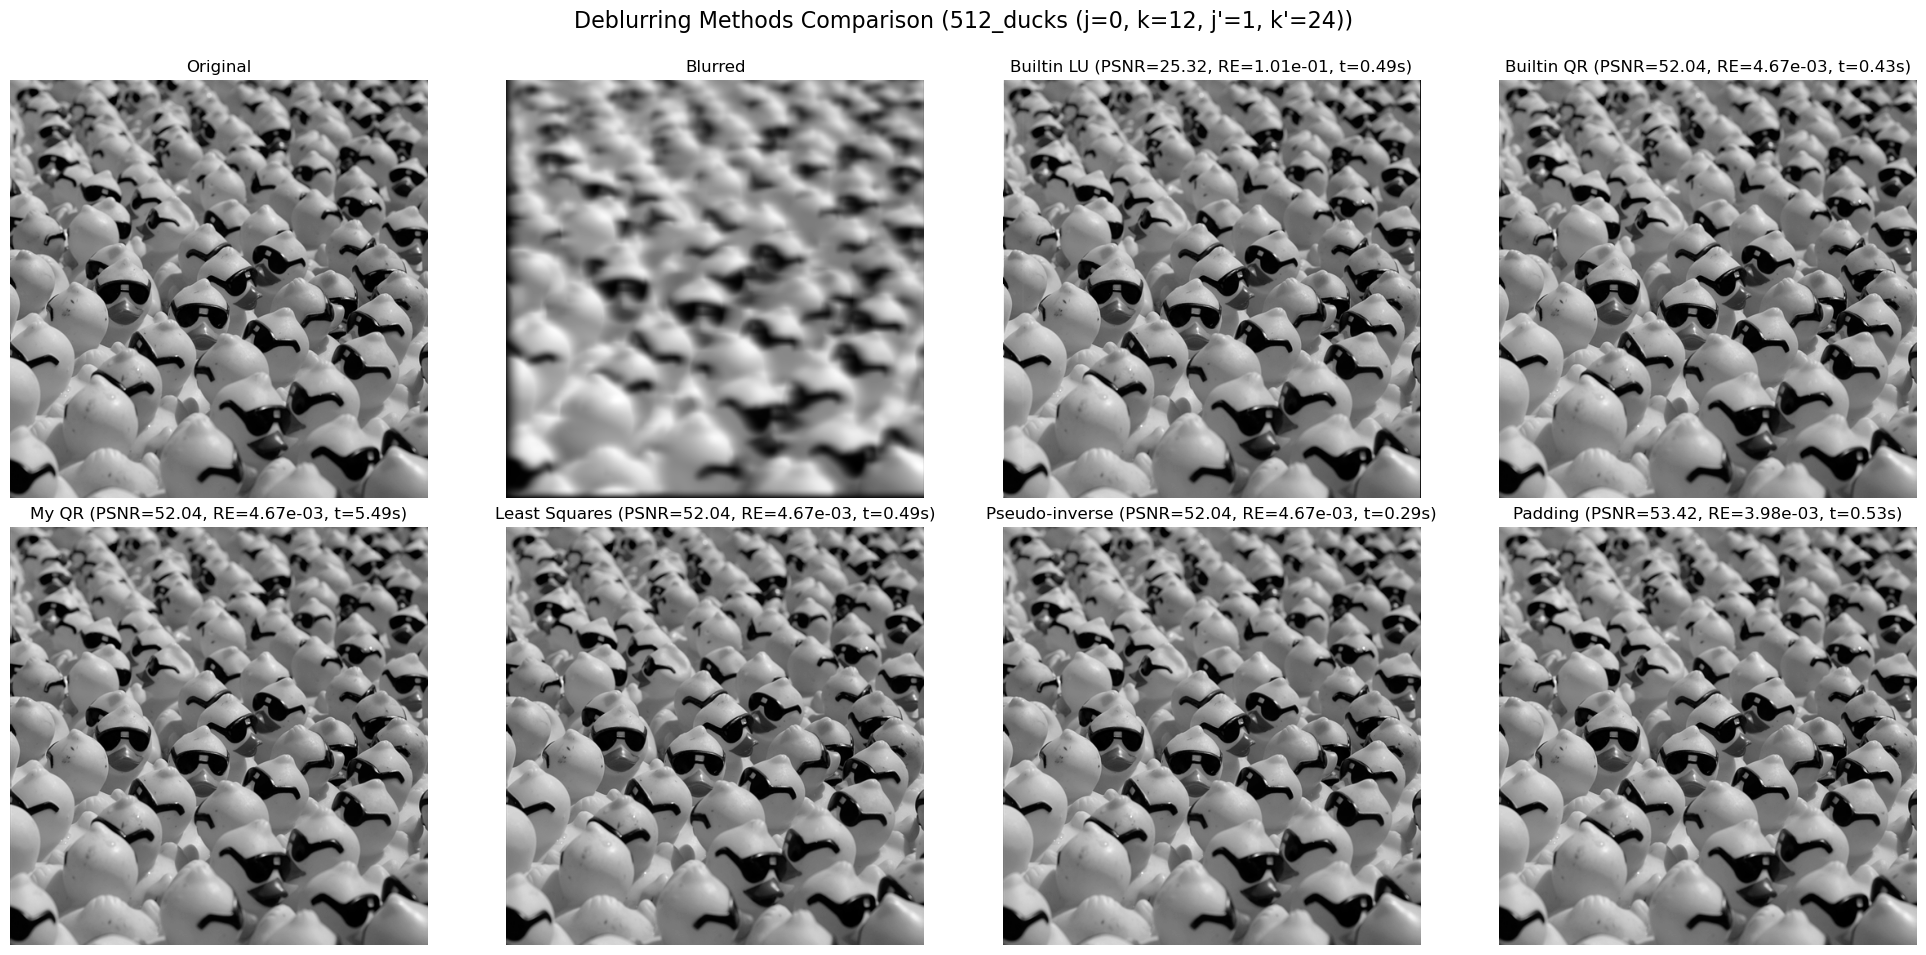

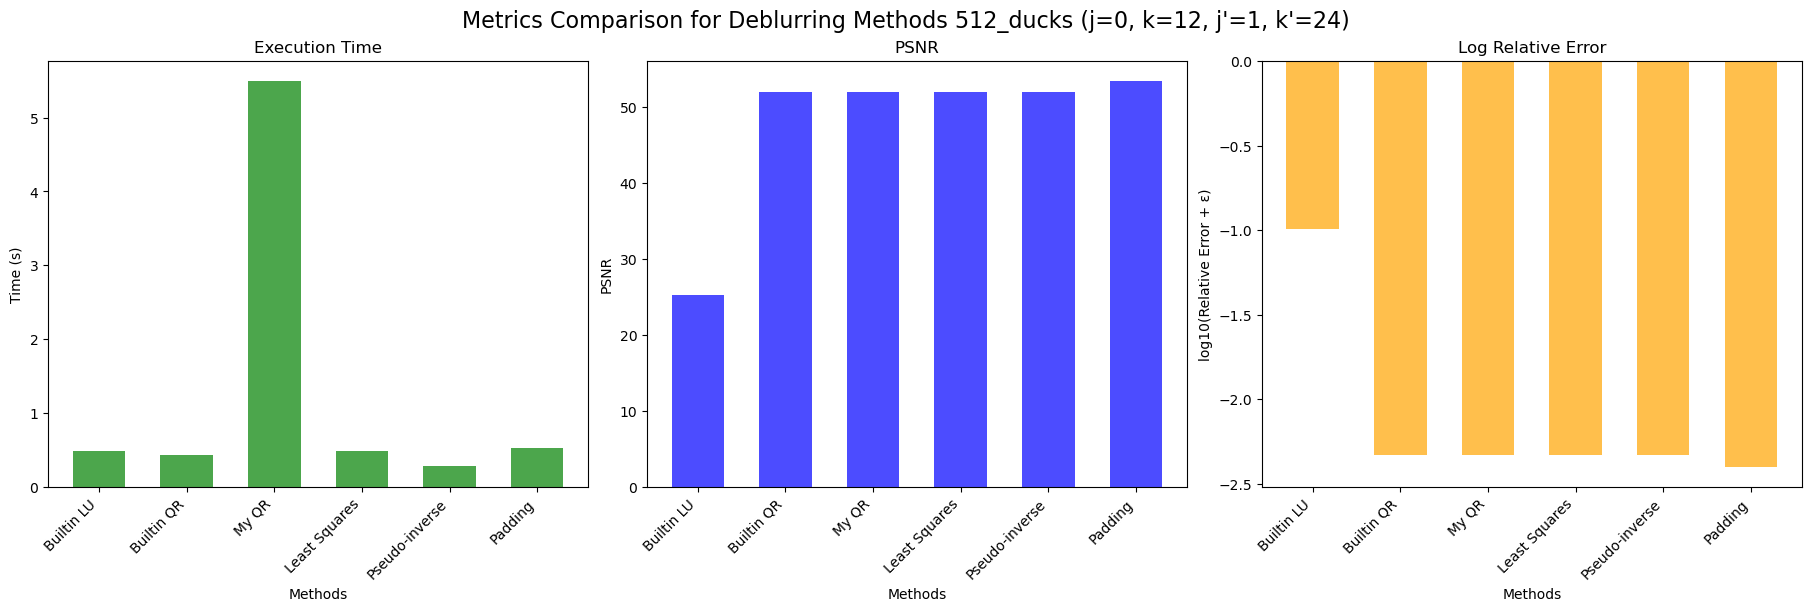

In [65]:
metrics_list[0][1] = deblur_comparison(X3, B3, Al3, Ar3,
                        info=img_list[1]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR1[0]}, k\'={jkR1[1]})')

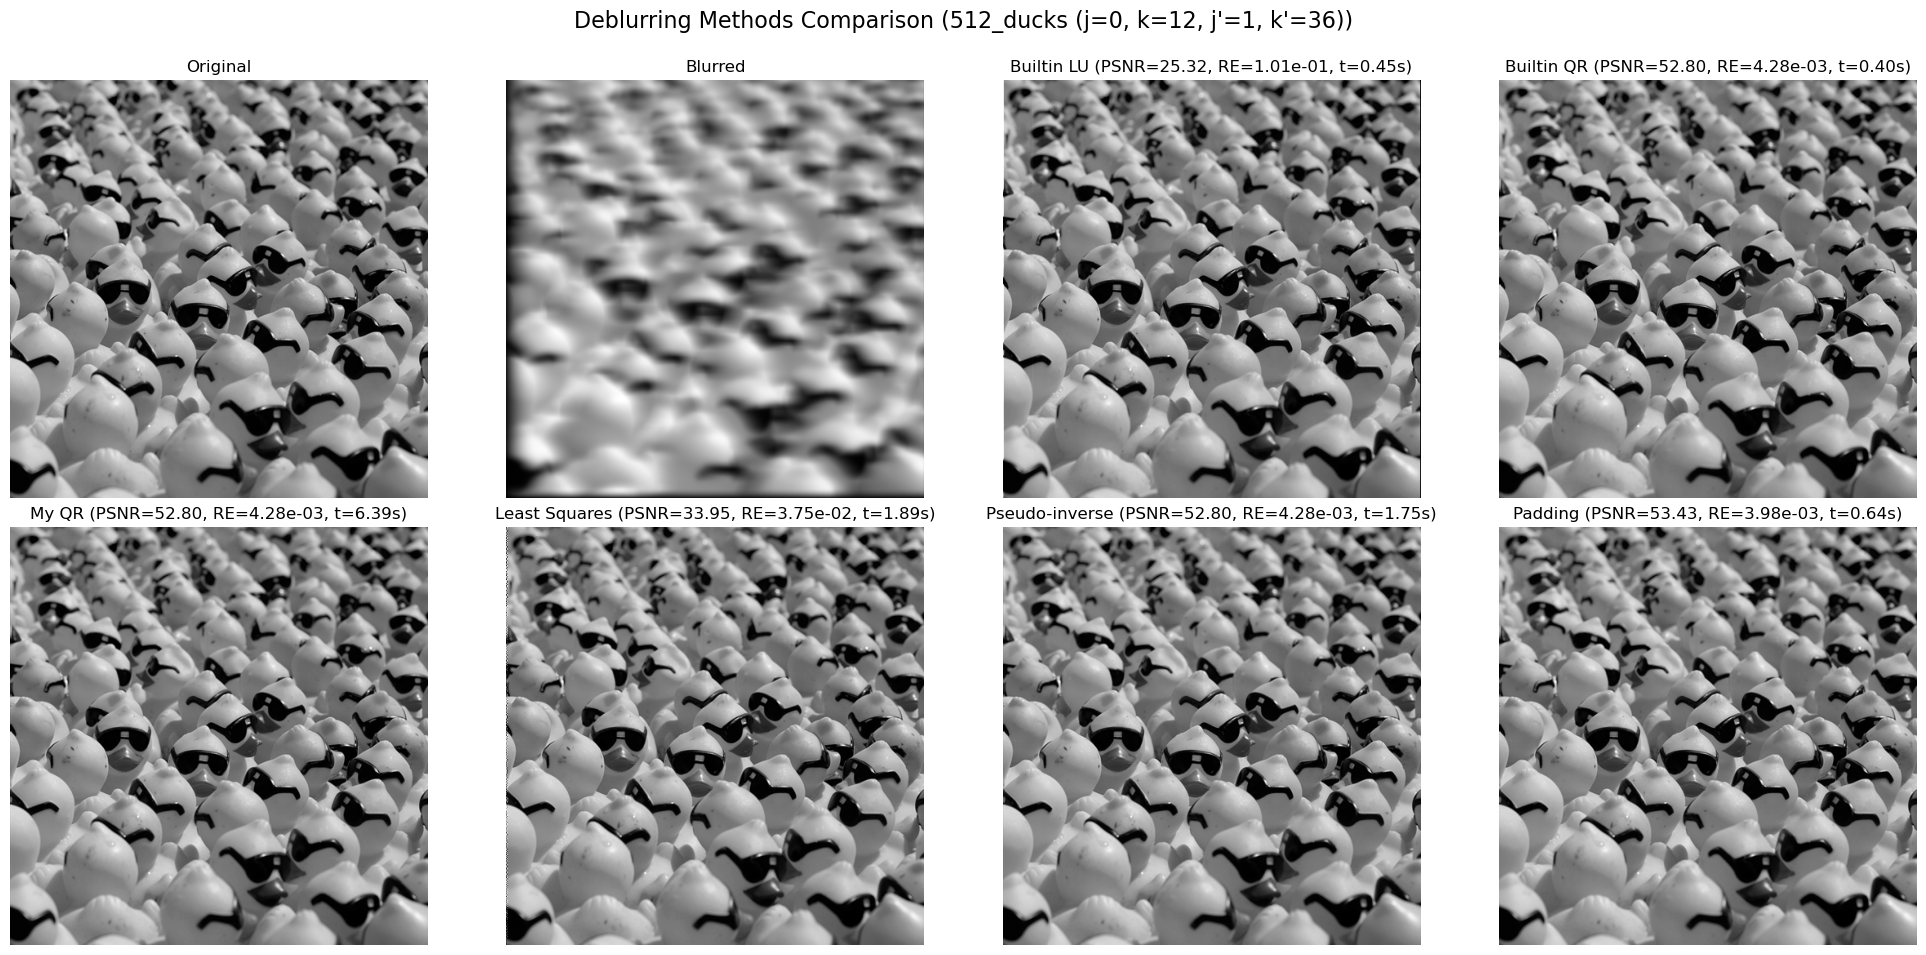

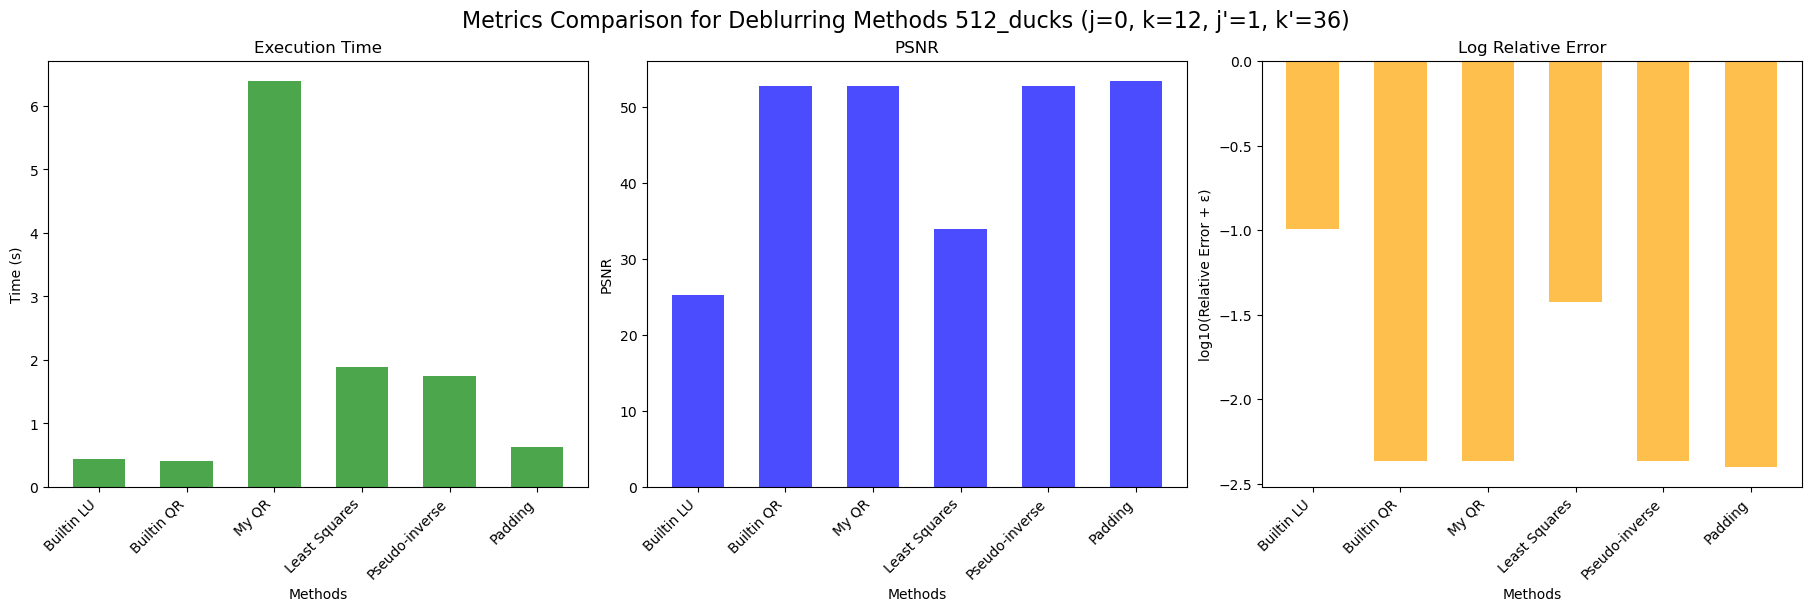

In [66]:
metrics_list[1][1] = deblur_comparison(X4, B4, Al4, Ar4,
                        info=img_list[1]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR2[0]}, k\'={jkR2[1]})')

---
## More results

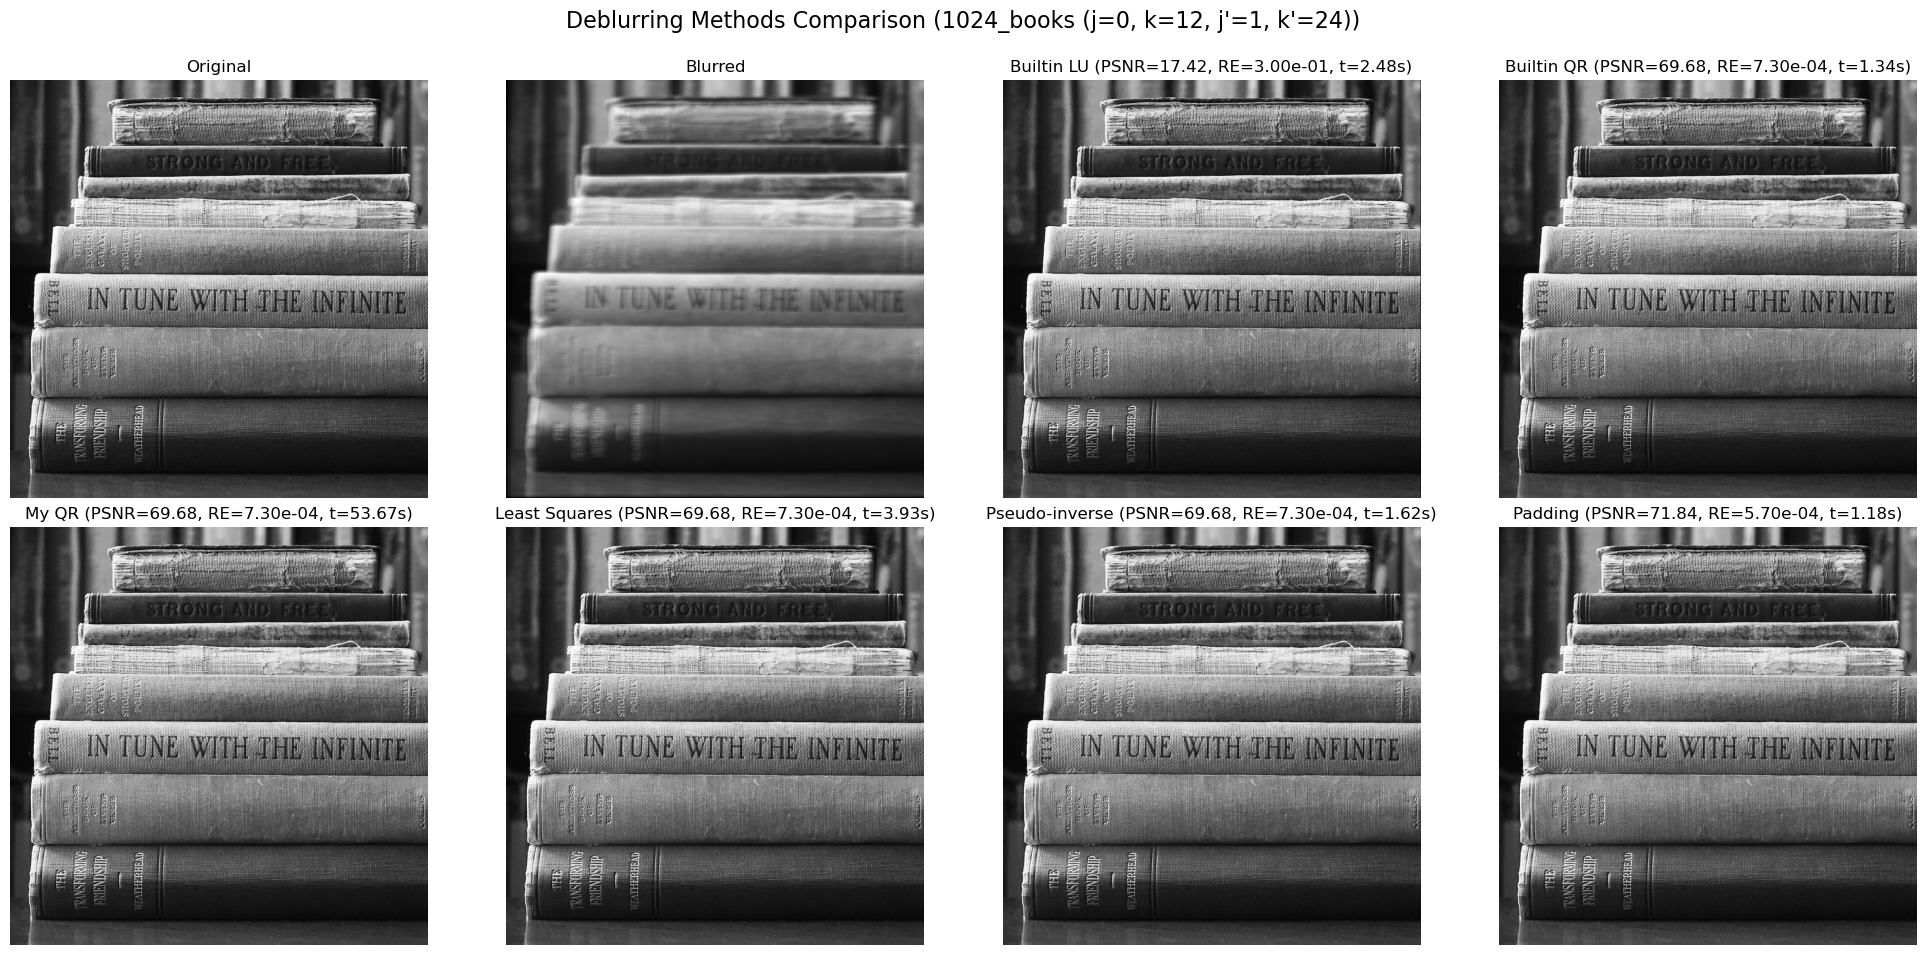

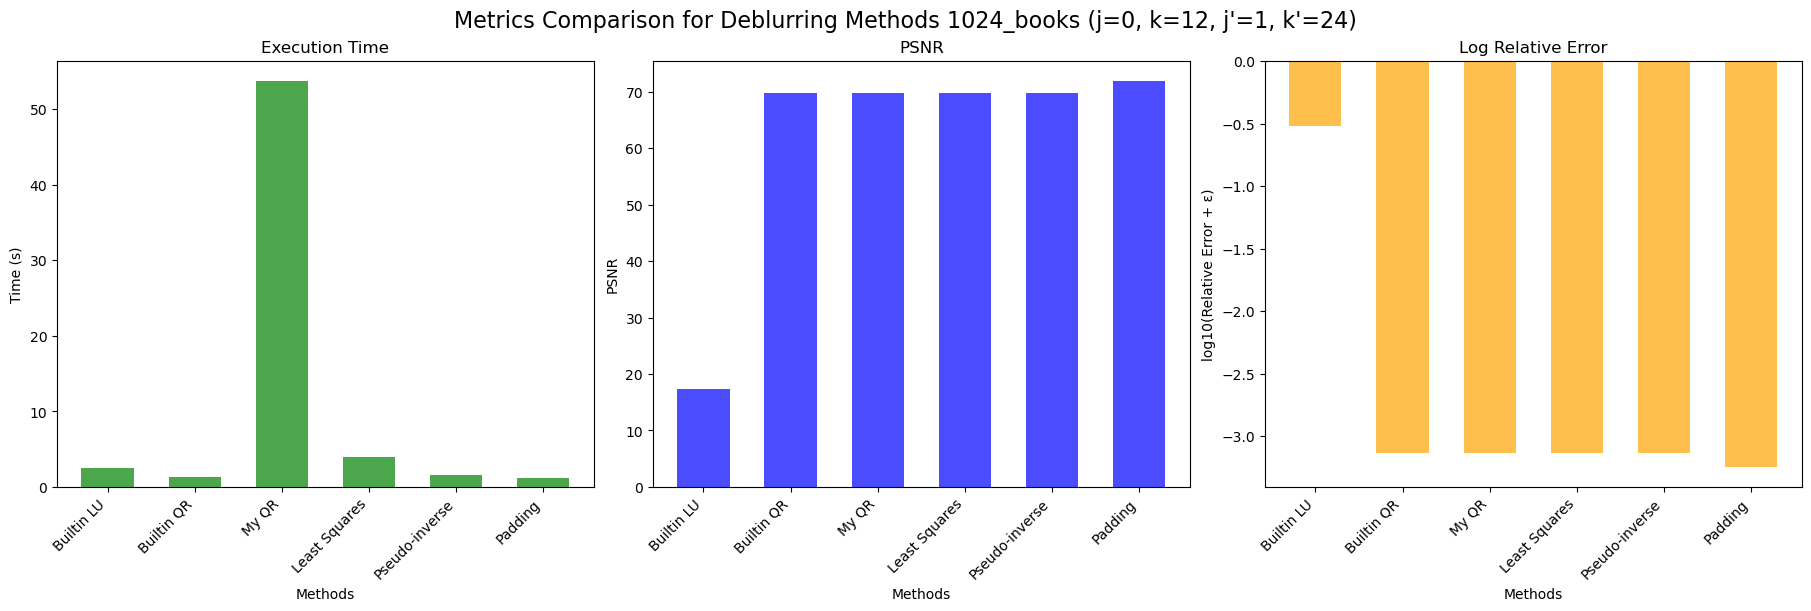

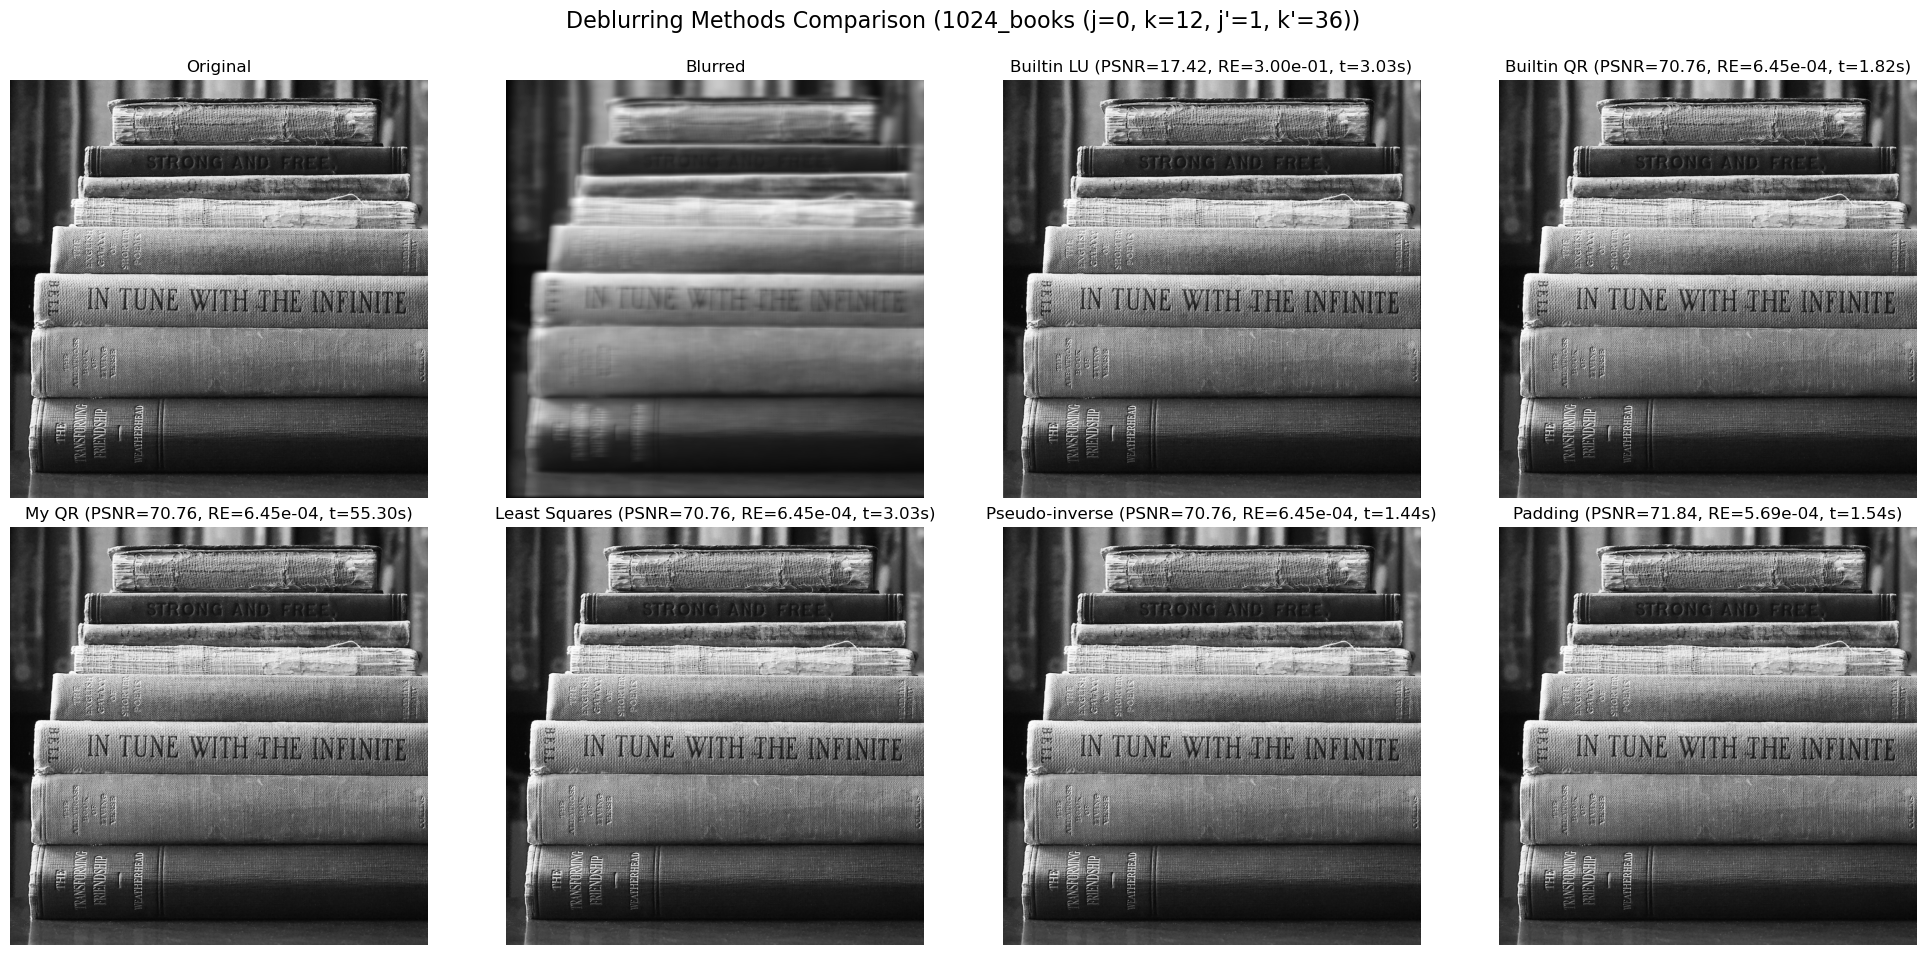

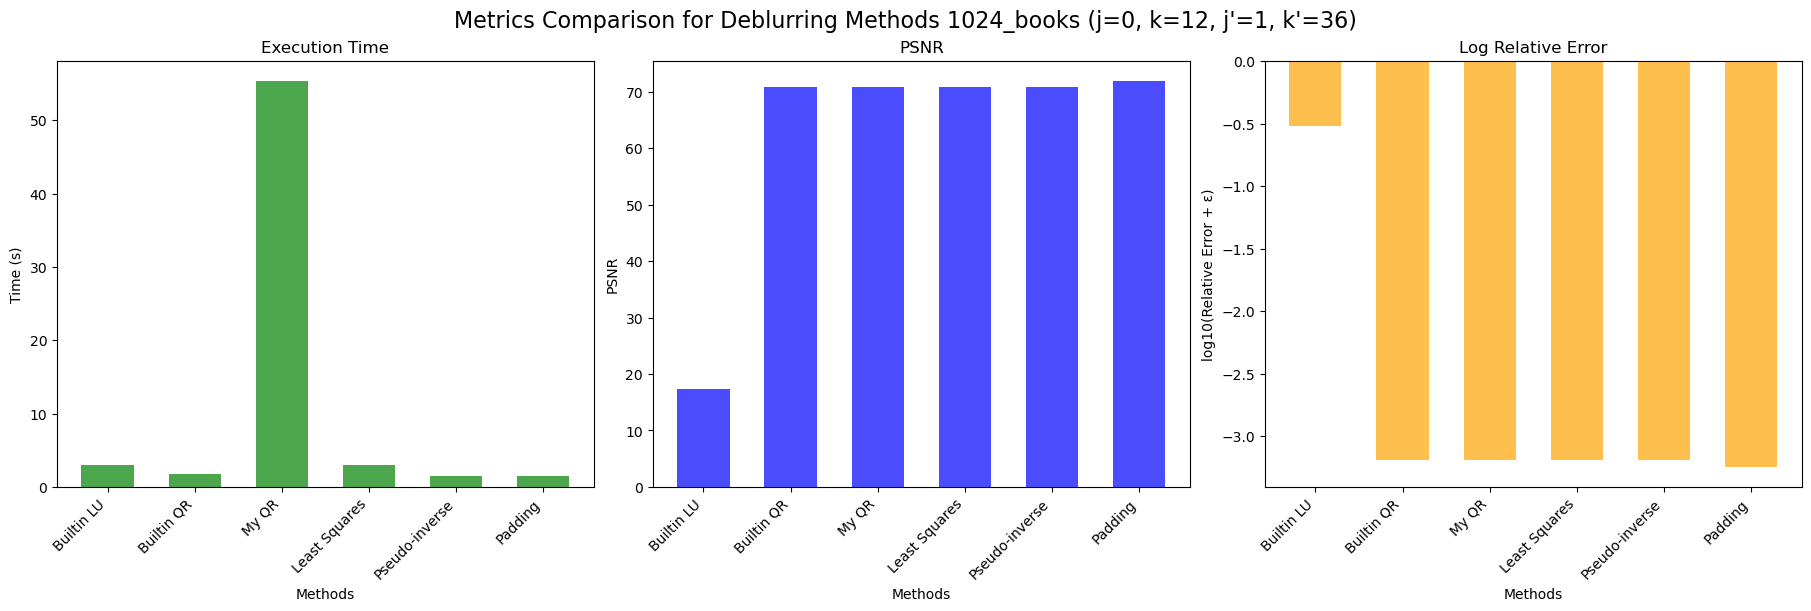

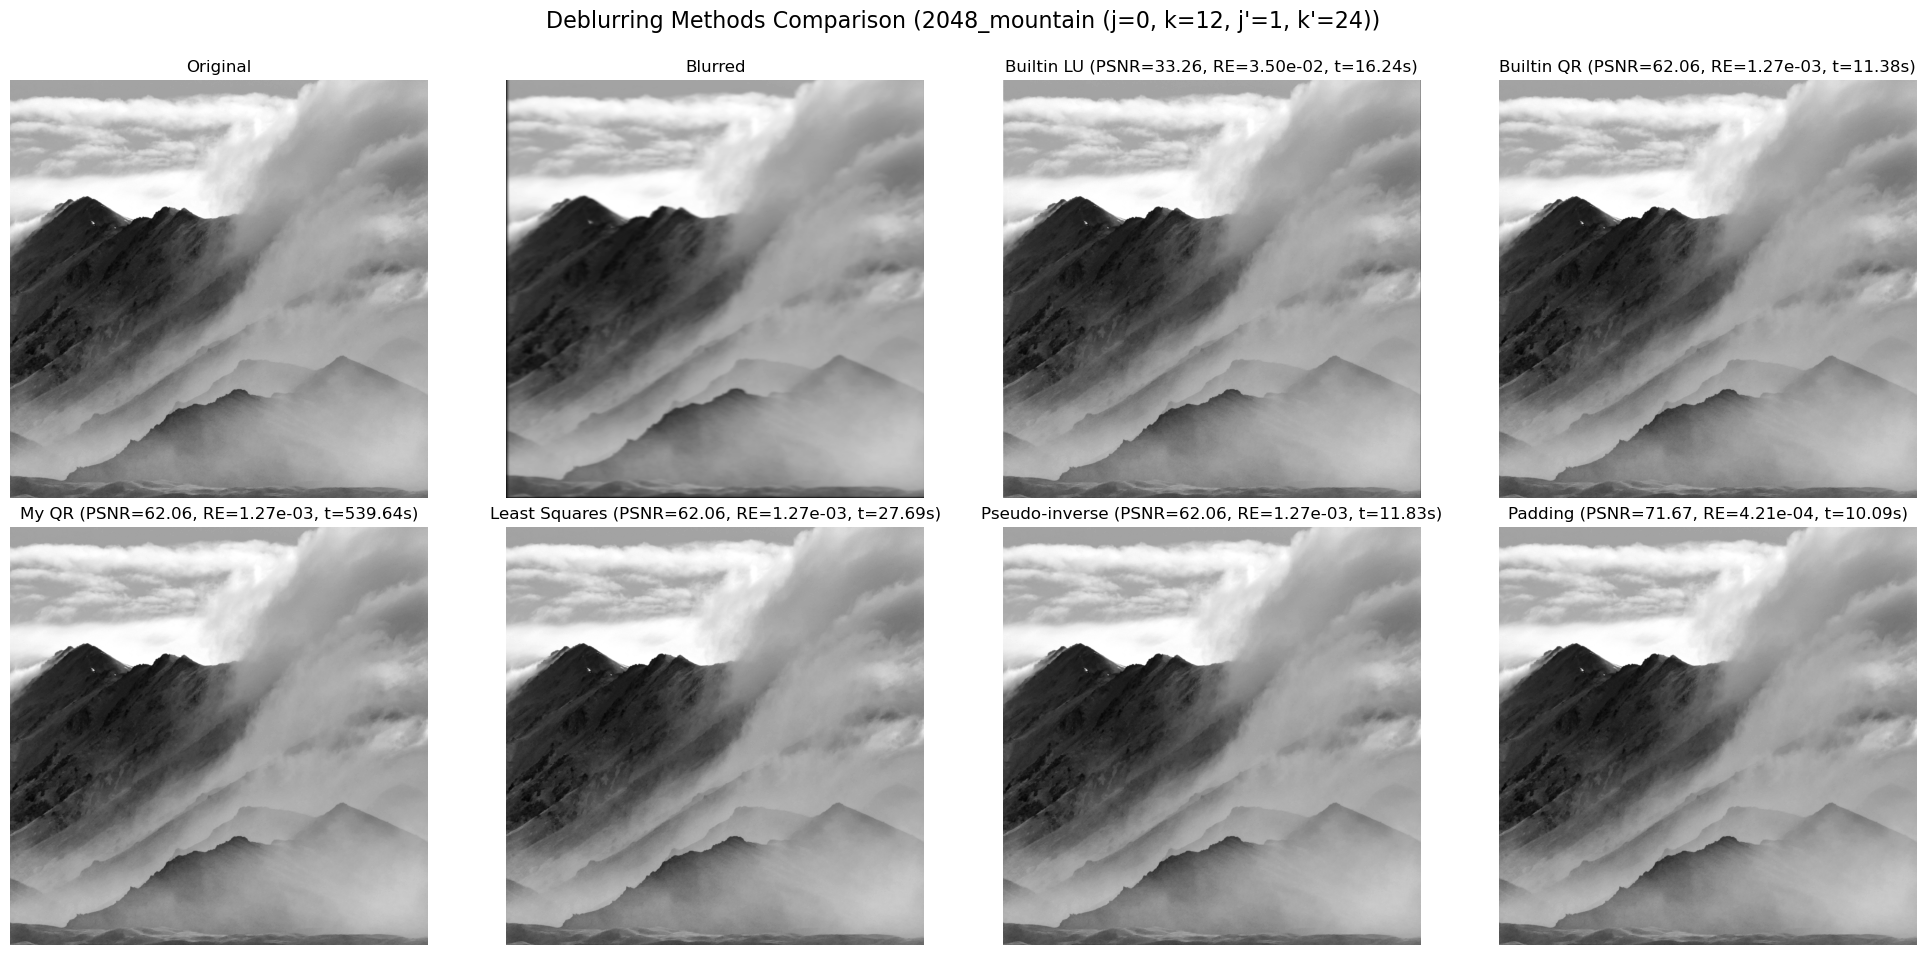

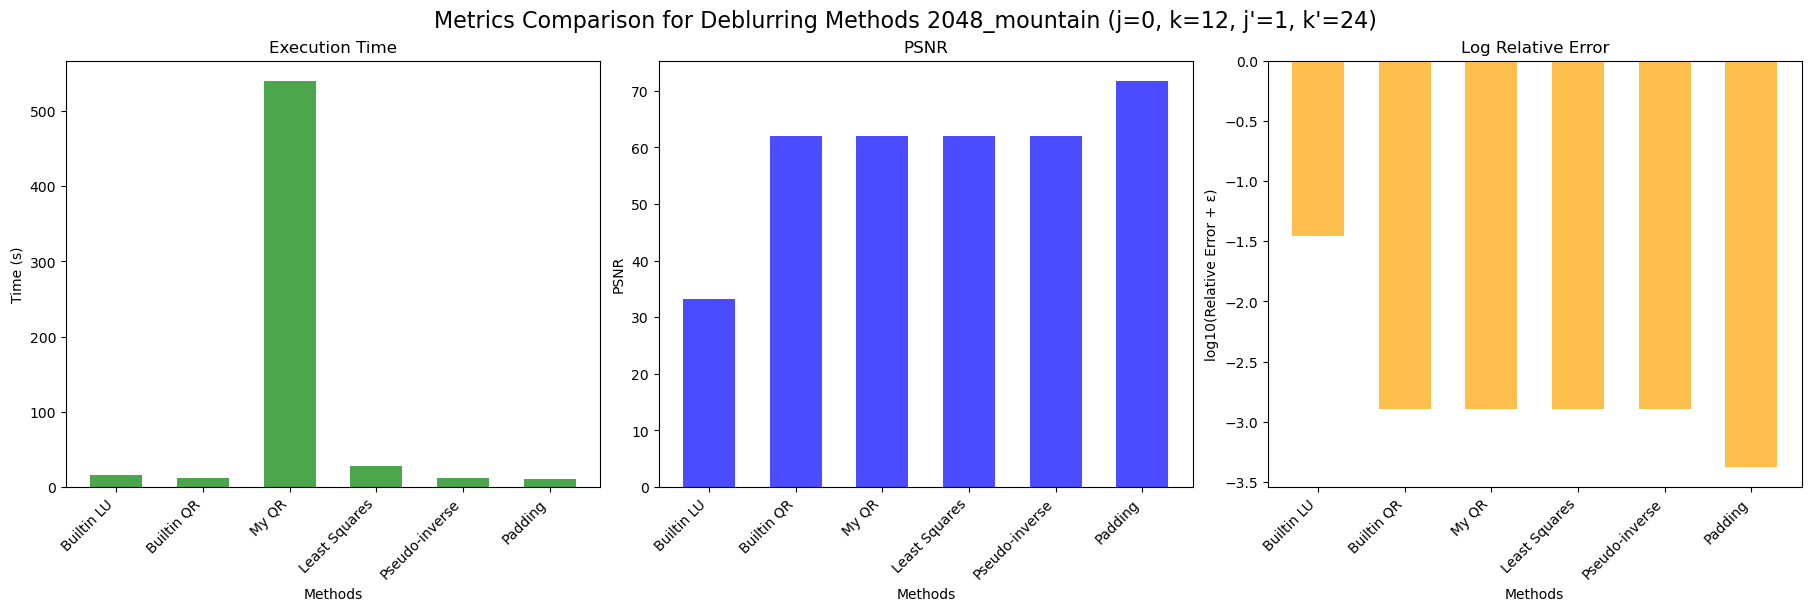

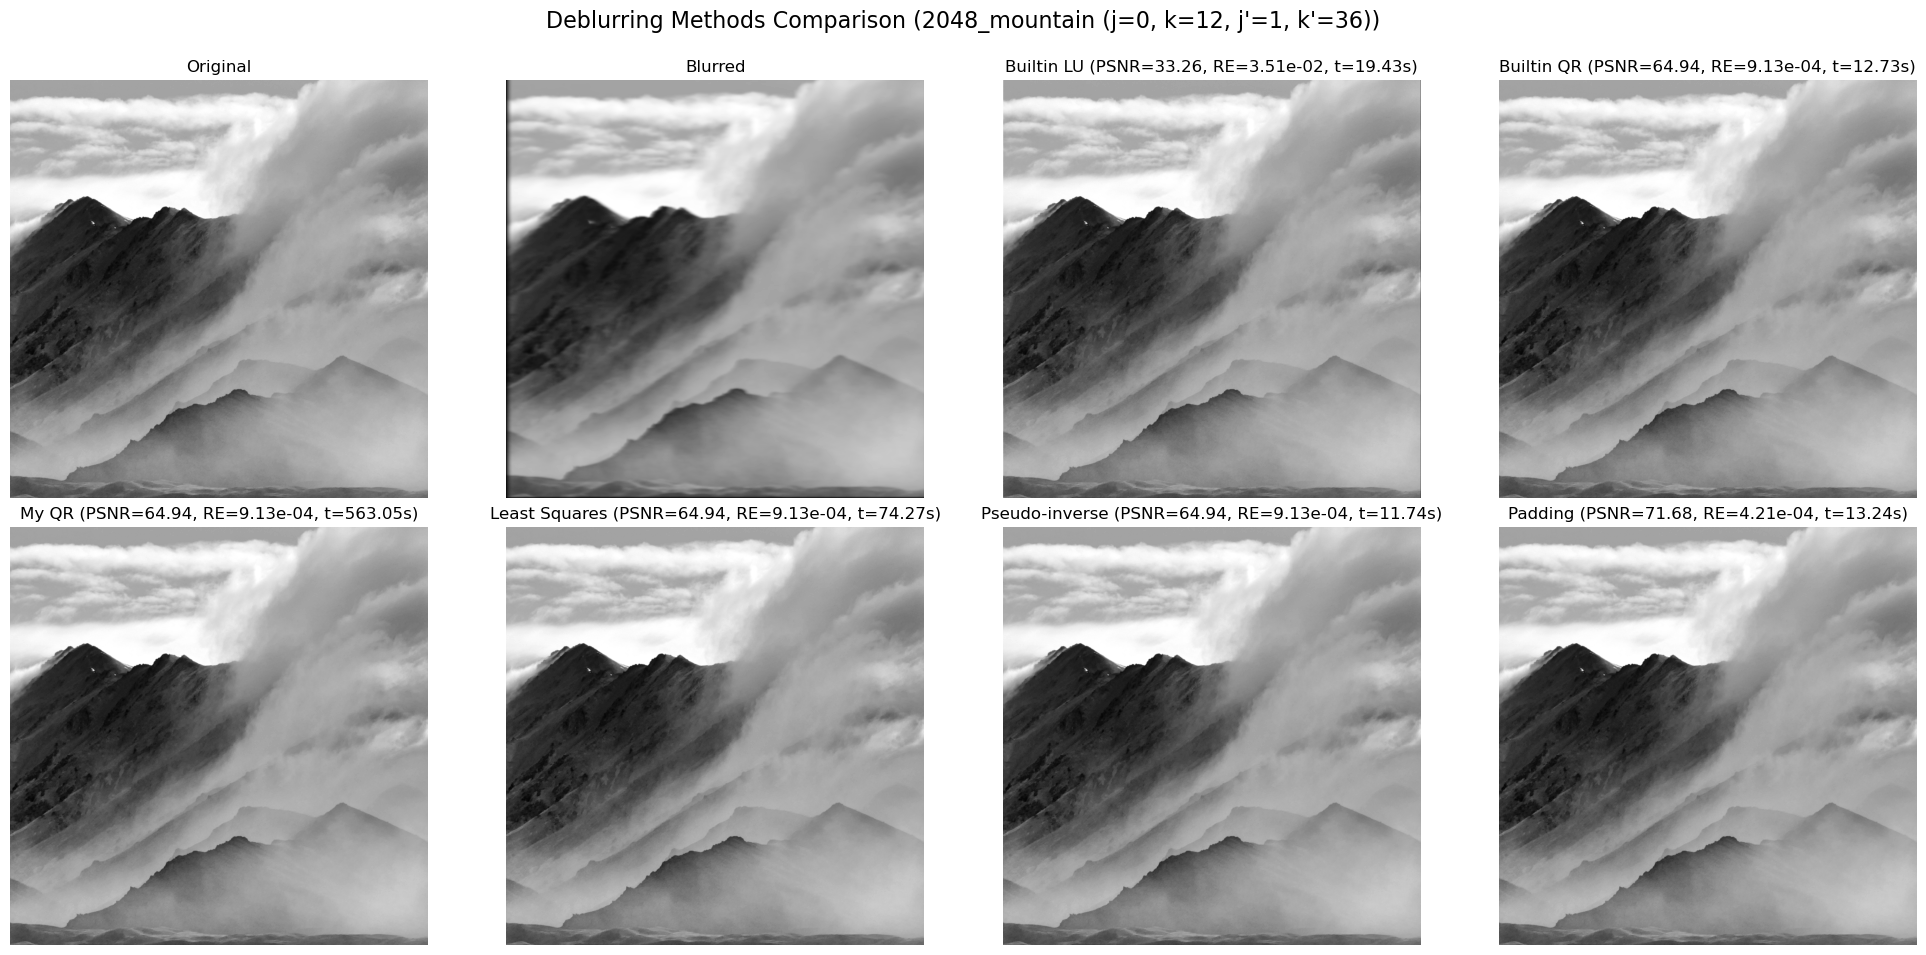

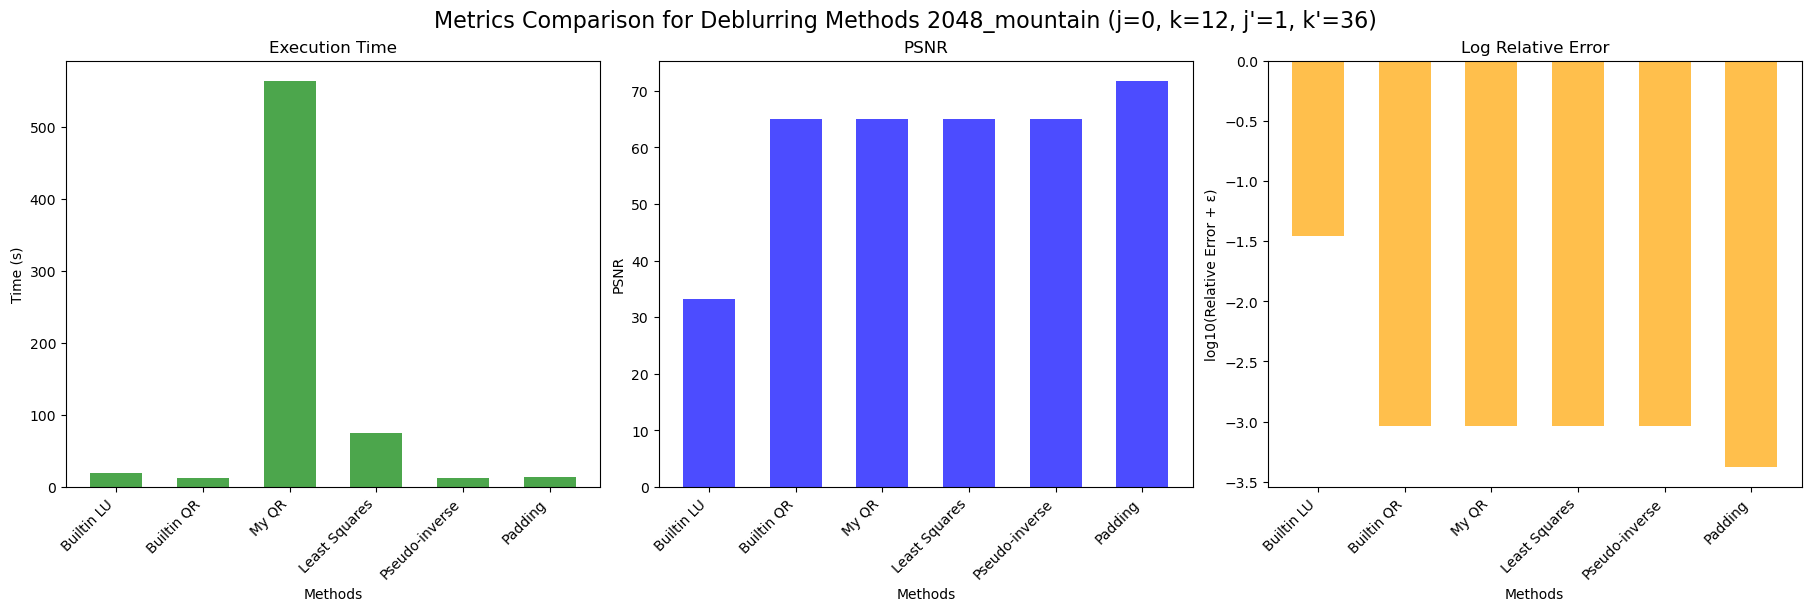

In [67]:
for i in range(2, len(img_list)):
    metrics_list[0][i] = deblur_comparison(*blur(img_list[i], jkL, jkR1),
                            info=img_list[i]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR1[0]}, k\'={jkR1[1]})')

    metrics_list[1][i] = deblur_comparison(*blur(img_list[i], jkL, jkR2),
                            info=img_list[i]+f' (j={jkL[0]}, k={jkL[1]}, j\'={jkR2[0]}, k\'={jkR2[1]})')

In [68]:
metrics_list[0][0]

[('Builtin LU', 0.22935009002685547, 28.663437172334497, 0.06835729406274393),
 ('Builtin QR', 0.22701597213745117, 75.26024562150641, 0.0003198485898187708),
 ('My QR', 1.0497641563415527, 74.89901492605259, 0.00033343100010993693),
 ('Least Squares',
  0.08550000190734863,
  64.29809197626524,
  0.001129931517102215),
 ('Pseudo-inverse',
  0.11255502700805664,
  75.18949538867864,
  0.0003224645309300552),
 ('Padding', 0.15953302383422852, 73.52540495399138, 0.00039055884134524407)]

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

def plot_metrics_from_list(img_list, metrics_list, info=''):
    methods = [metric[0] for metric in metrics_list[0][0]]
    x = img_list

    # Define color palette and line styles
    colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))
    line_styles = cycle(['-', '--'])

    # Create subplots for t, psnr_val, and log(relerr_val)
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    
    for i, method in enumerate(methods):
        for k, (k_value, linestyle) in enumerate(zip([24, 36], line_styles)):
            t_vals = [metric[i][1] for metric in metrics_list[k]]
            psnr_vals = [metric[i][2] for metric in metrics_list[k]]
            relerr_vals = [np.log10(metric[i][3] + 1e-6) for metric in metrics_list[k]]  # Log transform

            axs[0].plot(
                x, t_vals, label=f"{method} k={k_value}", marker='o',
                color=colors[i], linestyle=linestyle, alpha=0.8
            )
            axs[1].plot(
                x, psnr_vals, label=f"{method} k={k_value}", marker='o',
                color=colors[i], linestyle=linestyle, alpha=0.8
            )
            axs[2].plot(
                x, relerr_vals, label=f"{method} k={k_value}", marker='o',
                color=colors[i], linestyle=linestyle, alpha=0.8
            )
    
    # Display legend and set titles/labels
    titles = ["Execution Time", "PSNR", "Log Relative Error"]
    y_labels = ["Time (s)", "PSNR", "log10(Relative Error + ε)"]
    for ax, title, ylabel in zip(axs, titles, y_labels):
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel("Image")
        ax.set_ylabel(ylabel)
    
    # Add a super title for the plots
    fig.suptitle(f"Metrics Comparison {info}", fontsize=16)
    plt.show()


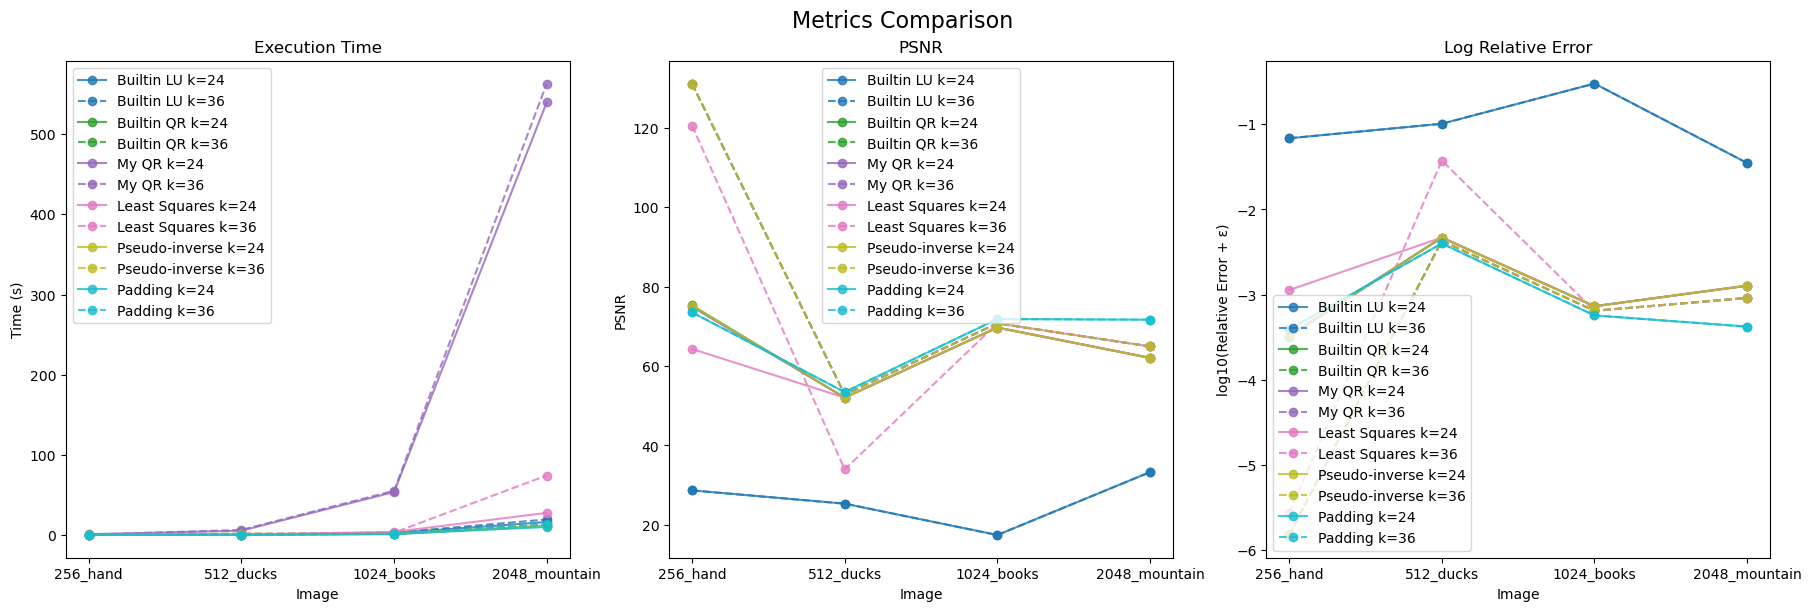

In [70]:
plot_metrics_from_list(img_list, metrics_list)